# Random Forest

### Importamos las bibliotecas

In [1]:
import mlflow
from mlflow.models import infer_signature

In [2]:
import pandas as pd
import numpy as np
import os
from scipy.stats import randint
import matplotlib.pyplot as plt

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import set_config

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

### Iniciamos el experimento de MLFlow

In [140]:
# Sets the sqlite db as the MLFLOW_TRACKING_URI 
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'

# WARNING: TO SEE THE LOCAL SERVER YOU HAVE TO CHOOSE THE CORRECT BACKEND STORE AS FOLLOWS:
# mlflow ui --port 8080 --backend-store-uri sqlite:///mlruns.db


# mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

Creación del experimento en MLFlow

In [35]:
# Definimos el experimento el que guardaré todas las ejecuciones
mlflow.set_experiment(experiment_name = 'Random Forest')

<Experiment: artifact_location=('file:///c:/Users/carme/OneDrive - Universidad Complutense de Madrid '
 '(UCM)/SEGUNDO/SEGUNDO CUATRI/PD1/mlruns/1'), creation_time=1713003875041, experiment_id='1', last_update_time=1713003875041, lifecycle_stage='active', name='Random Forest', tags={}>

### Cargamos los datos

In [5]:
# Cargamos el df
df = pd.read_csv('datosEntrenamientoModelosFinal.csv')
df

,Bestseller,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,BookInterest1M,...,World History,World War I,World War II,Writing,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
0,0.0,329.0,1.0,0.51,0.40,0,19.99,1.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,269.0,2.0,0.61,0.54,1,3.99,2.0,ebook,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2335.0,1.0,0.72,0.57,1,20.99,7.0,ebook,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,40.0,1.0,0.83,0.35,0,25.00,1.0,hardcover,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,189.0,1.0,0.59,0.26,0,15.00,4.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,0.0,432.0,1.0,0.40,0.38,1,25.35,5.0,hardcover,100.0,...,0,0,0,0,0,0,0,0,0,0
3686,0.0,304.0,1.0,0.27,0.28,0,18.99,3.0,paperback,103.0,...,0,0,0,0,0,0,0,0,0,0
3687,0.0,160.0,1.0,0.10,0.16,0,15.39,5.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0
3688,0.0,304.0,1.0,0.51,0.43,0,25.19,3.0,hardcover,590.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Proporción de clases inicial
porcentaje_clases = df['Bestseller'].value_counts(normalize=True) * 100
print("Porcentaje de cada clase en la columna 'potencialBS':")
print(porcentaje_clases)

Porcentaje de cada clase en la columna 'potencialBS':
Bestseller
0.0    84.95935
1.0    15.04065
Name: proportion, dtype: float64


### Establecemos las métricas

In [16]:
# Función para calcular la sensibilidad (recall)
def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

# Función para calcular la especificidad
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Convertir las funciones en funciones de puntuación para usar en RandomizedSearchCV
sensitivity_scorer = make_scorer(sensitivity)
specificity_scorer = make_scorer(specificity)

METRICS = {'balanced_accuracy': 'balanced_accuracy', 'sensitivity': sensitivity_scorer, 'specificity': specificity_scorer}

### Variables constantes

In [8]:
# Semilla
SEED = 22

# Proporción del conjunto de test
TEST_SIZE = 0.3

# Número de folds para la validación cruzada
CV_FOLDS = 5

### Creamos los folds

In [36]:
kf = StratifiedKFold(n_splits= CV_FOLDS, shuffle= True, random_state = SEED)

### Modelo baseline

En primer lugar realizaremos un modelo baseline que usaremos como base para poder comparar el rendimiento con los modelos más complejos que realizaremos después. En este modelo:
- No realizamos oversampling (SMOTE)
- No transformamos variables
- No hacemos selección de variables
- Usamos los hiperparámetros por defecto de RandomForestClassifier
  - n_estimators: 100
  - criterion: gini
  - max_depth: None
  - min_samples_split: 2
  - min_samples_leaf: 1

In [24]:
# Codificamos la variable 'PriceFormat'
df_baseline = pd.get_dummies(df, columns=['PriceFormat'], dtype=int)
df_baseline

,Bestseller,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,BookInterest1M,Rating20Days,...,Writing,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies,PriceFormat_ebook,PriceFormat_hardcover,PriceFormat_paperback
0,0.0,329.0,1.0,0.51,0.40,0,19.99,1.0,0.0,3.70,...,0,0,0,0,0,0,0,0,0,1
1,0.0,269.0,2.0,0.61,0.54,1,3.99,2.0,0.0,3.89,...,0,0,0,0,0,0,0,1,0,0
2,0.0,2335.0,1.0,0.72,0.57,1,20.99,7.0,0.0,4.45,...,0,1,0,0,0,0,0,1,0,0
3,0.0,40.0,1.0,0.83,0.35,0,25.00,1.0,0.0,4.30,...,0,1,0,0,0,0,0,0,1,0
4,0.0,189.0,1.0,0.59,0.26,0,15.00,4.0,0.0,3.80,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,0.0,432.0,1.0,0.40,0.38,1,25.35,5.0,100.0,4.48,...,0,0,0,0,0,0,0,0,1,0
3686,0.0,304.0,1.0,0.27,0.28,0,18.99,3.0,103.0,3.91,...,0,0,0,0,0,0,0,0,0,1
3687,0.0,160.0,1.0,0.10,0.16,0,15.39,5.0,0.0,3.96,...,0,0,0,0,0,0,0,0,0,1
3688,0.0,304.0,1.0,0.51,0.43,0,25.19,3.0,590.0,4.08,...,0,0,0,0,0,0,0,0,1,0


In [26]:
# Seleccionamos X e y
X_baseline = df_baseline.iloc[:, 1:]
y_baseline = df_baseline.iloc[:, 0:1]

In [107]:
# Partición en train y test
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline, y_baseline, test_size=TEST_SIZE, stratify=y_baseline, random_state=SEED)

In [112]:
print(X_train_baseline.shape, X_test_baseline.shape, y_train_baseline.shape, y_test_baseline.shape)

(2583, 346) (1107, 346) (2583, 1) (1107, 1)


In [124]:
# Creando el clasificador Random Forest
rf_classifier = RandomForestClassifier(random_state=SEED)

rf_classifier.fit(X_train_baseline, y_train_baseline)

# Realizando validación cruzada
cv_scores = cross_validate(rf_classifier, X_train_baseline, y_train_baseline, cv=kf, scoring=METRICS, return_train_score=True, verbose=1, n_jobs=-1)

c:\Users\carme\OneDrive - Universidad Complutense de Madrid (UCM)\SEGUNDO\SEGUNDO CUATRI\PD1\NOVELLA\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


In [125]:
# Mostramos los resultados de la validación cruzada como un dataframe
df_results = pd.DataFrame(cv_scores)
df_results

,fit_time,score_time,test_balanced_accuracy,train_balanced_accuracy,test_sensitivity,train_sensitivity,test_specificity,train_specificity
0,0.962132,0.050045,0.664389,1.0,0.333333,1.0,0.995444,1.0
1,0.977798,0.051068,0.754132,1.0,0.512821,1.0,0.995444,1.0
2,0.994822,0.052013,0.691169,1.0,0.384615,1.0,0.997722,1.0
3,1.091995,0.045400,0.648138,1.0,0.307692,1.0,0.988584,1.0
4,1.103997,0.048806,0.653226,1.0,0.324675,1.0,0.981777,1.0


Registramos los resultados en MLFlow

In [54]:
# Registramos los resultados en MLFlow
with mlflow.start_run():

    # Los hiperparámetros tienen los valores por defecto
    mlflow.log_param("n_estimators", rf_classifier.n_estimators)
    mlflow.log_param("criterion", rf_classifier.criterion)
    mlflow.log_param("max_depth", rf_classifier.max_depth)
    mlflow.log_param("min_samples_split", rf_classifier.min_samples_split)
    mlflow.log_param("min_samples_leaf", rf_classifier.min_samples_leaf)

    # Registra las métricas de cada fold para cada métrica
    for metric in METRICS:
        
        # Media
        mlflow.log_metric(f"mean_train_{metric}", np.mean(df_results[f"train_{metric}"]))
        mlflow.log_metric(f"mean_test_{metric}", np.mean(df_results[f"test_{metric}"]))

        # Desviación típica
        mlflow.log_metric(f"std_train_{metric}", np.std(df_results[f"train_{metric}"]))
        mlflow.log_metric(f"std_test_{metric}", np.std(df_results[f"test_{metric}"]))

        for i in range(5):

            # Resultados de entrenamiento en cada fold
            mlflow.log_metric(f"train_{metric}_fold_{i}", df_results[f"train_{metric}"][i])
            # Resultados de validación en cada fold
            mlflow.log_metric(f"test_{metric}_fold_{i}", df_results[f"test_{metric}"][i])

    # Establece una etiqueta que describe el propósito de esta ejecución
    mlflow.set_tag("Información", "Baseline model")

    # Infiere el signature del modelo, que describe el tipo de entrada y salida del modelo
    signature = infer_signature(X_train_baseline, rf_classifier.predict(X_train_baseline))

    # Registra el modelo
    model_info = mlflow.sklearn.log_model(
        sk_model=rf_classifier,
        artifact_path="rf_model_baseline",
        signature=signature,
        input_example=X_train_baseline,
        registered_model_name="rf_baseline",
    )

c:\Users\carme\OneDrive - Universidad Complutense de Madrid (UCM)\SEGUNDO\SEGUNDO CUATRI\PD1\NOVELLA\venv\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/04/16 00:52:25 WARNING mlflow.utils.validation: Tag value '[{"run_id": "d389d523fe624b1488c92aa915d2cc95", "artifact_path": "rf_model_baseline", "utc_time_crea

### Modelos aplicando oversampling y ajuste de hiperparámetros

In [55]:
# Seleccionamos X e y
X = df.iloc[:, 1:]
y = df.iloc[:, 0:1]

In [59]:
# Partición en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=SEED)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2583, 344) (1107, 344) (2583, 1) (1107, 1)


In [60]:
# Comprobamos que las proporciones iniciales de ambas clases se mantienen (85/15)
print("Porcentaje de cada clase en y_train:")
print(y_train.value_counts(normalize=True))
print("Porcentaje de cada clase en y_test:")
print(y_test.value_counts(normalize=True))

Porcentaje de cada clase en y_train:
Bestseller
0.0           0.8494
1.0           0.1506
Name: proportion, dtype: float64
Porcentaje de cada clase en y_test:
Bestseller
0.0           0.850045
1.0           0.149955
Name: proportion, dtype: float64


### Oversampling

Realizamos oversampling en nuestra clase minoritaria. Para ello emplearemos SMOTENC ya que acepta variables numéricas y categóricas.

In [61]:
# Seleccionamos las variables categóricas para pasárselas a SMOTENC

# Columnas de los géneros
columnas_generos = df.columns[14:]

# Columnas categóricas
categoricalColumns = ["BelongsSaga", "PriceFormat", "HasTwitter", "HasWikipedia"] + list(columnas_generos)

### Contruimos el pipeline

In [ ]:
# Para poder visualizar el pipeline
set_config(display="diagram")

In [63]:
# Redondea las variables que toman valores enteros
def redondearVariables(X):
    variablesRedondeo = ["NumPages", "SagaNumber", "WordsTitle"]
    # Itera sobre las columnas especificadas y redondea sus valores
    for v in variablesRedondeo:
        X[v] = np.round(X[v])
    return X

In [65]:
# Oversampling
smote = SMOTENC(categorical_features = categoricalColumns, random_state = SEED)

# Definimos el clasificador RandomForest
rf_classifier = RandomForestClassifier(random_state=SEED)

# Definimos el transformador para codificar la variable categórica 'PriceFormat'
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['PriceFormat'])
], remainder='passthrough')

# Definimos el transformador de la función para redondear
transformador_funcion = FunctionTransformer(func=redondearVariables)

# Construimos el pipeline
pipeline = Pipeline([
    ('smote', smote),
    ('redondear_variables', transformador_funcion),
    ('encoder', column_transformer),
    ('classifier', rf_classifier)
])

In [66]:
pipeline

Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=['BelongsSaga', 'PriceFormat',
                                               'HasTwitter', 'HasWikipedia',
                                               '19th Century', '20th Century',
                                               'Abuse', 'Action', 'Adoption',
                                               'Adult', 'Adult Fiction',
                                               'Adventure', 'Africa',
                                               'African American',
                                               'African American Romance',
                                               'African Literature', 'Aliens',
                                               'Alternate History',
                                               'Amateur Sleuth', 'Amazon',
                                               'American', 'American His...
                                               'Americana', 'Amish', 'Angels',
                                               'Animals', 'Anthologies',
                                               'Apocalyptic', 'Apple', 'Art', ...],
                         random_state=22)),
                ('redondear_variables',
                 FunctionTransformer(func=<function redondearVariables at 0x0000026418A908B0>)),
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe', OneHotEncoder(),
                                                  ['PriceFormat'])])),
                ('classifier', RandomForestClassifier(random_state=22))])

### Ajuste de hiperparámetros con GridSearch

In [68]:
# Defino el grid con los hiperparámetros (162 combinaciones)
param_grid = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Inicializo GridSearch
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kf,
                           scoring=METRICS,
                           return_train_score=True,
                           refit="balanced_accuracy",
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Resultados
cv_results = grid_search.cv_results_
best_params = grid_search.best_params_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\carme\OneDrive - Universidad Complutense de Madrid (UCM)\SEGUNDO\SEGUNDO CUATRI\PD1\NOVELLA\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [69]:
# Convertimos los resultados de la validación cruzada en un dataframe
df_cv_results = pd.DataFrame(cv_results)
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,...,mean_test_specificity,std_test_specificity,rank_test_specificity,split0_train_specificity,split1_train_specificity,split2_train_specificity,split3_train_specificity,split4_train_specificity,mean_train_specificity,std_train_specificity
0,27.688554,0.356765,0.050807,0.011444,gini,None,1,2,10,"{'classifier__criterion': 'gini', 'classifier_...",...,0.956700,0.006602,25,0.998291,0.998860,0.999430,1.000000,1.000000,0.999316,0.000664
1,27.683824,1.003983,0.092162,0.021276,gini,None,1,2,50,"{'classifier__criterion': 'gini', 'classifier_...",...,0.965364,0.010905,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,28.698999,0.733755,0.161632,0.027452,gini,None,1,2,100,"{'classifier__criterion': 'gini', 'classifier_...",...,0.965361,0.010719,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,26.305042,0.660937,0.049793,0.014682,gini,None,1,5,10,"{'classifier__criterion': 'gini', 'classifier_...",...,0.950773,0.014092,43,0.996581,0.994872,0.996011,0.996014,0.994872,0.995670,0.000684
4,27.434391,0.584126,0.092351,0.039266,gini,None,1,5,50,"{'classifier__criterion': 'gini', 'classifier_...",...,0.965359,0.008330,7,0.999430,0.999430,0.998860,0.999431,0.999430,0.999316,0.000228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,26.189477,1.971620,0.065371,0.010632,entropy,20,4,5,50,"{'classifier__criterion': 'entropy', 'classifi...",...,0.935738,0.020023,86,0.960684,0.949288,0.948718,0.964692,0.968091,0.958295,0.007943
158,26.497118,1.836967,0.072725,0.017796,entropy,20,4,5,100,"{'classifier__criterion': 'entropy', 'classifi...",...,0.937559,0.017196,80,0.957265,0.949858,0.953276,0.964692,0.967521,0.958523,0.006682
159,26.005602,0.967840,0.050136,0.017161,entropy,20,4,10,10,"{'classifier__criterion': 'entropy', 'classifi...",...,0.919788,0.010084,139,0.947009,0.939601,0.921368,0.941913,0.944729,0.938924,0.009129
160,23.721582,0.241473,0.043613,0.009306,entropy,20,4,10,50,"{'classifier__criterion': 'entropy', 'classifi...",...,0.934373,0.010091,94,0.958405,0.950997,0.940741,0.970387,0.963533,0.956812,0.010238


In [81]:
# Seleccionamos la fila con los mejores parámetros
filtered_row = df_cv_results.loc[
    (df_cv_results['param_classifier__criterion'] == best_params['classifier__criterion']) &
    (df_cv_results['param_classifier__max_depth'] == best_params['classifier__max_depth']) &
    (df_cv_results['param_classifier__min_samples_leaf'] == best_params['classifier__min_samples_leaf']) &
    (df_cv_results['param_classifier__min_samples_split'] == best_params['classifier__min_samples_split']) &
    (df_cv_results['param_classifier__n_estimators'] == best_params['classifier__n_estimators'])
]

# Obtenemos su índice en el dataframe
index_row = filtered_row.index[0]
index_row

29

Importancia de las variables

Para estudiar la importancia de las variables usamos la 'permutation importance' ya que puede ser más exacta que el atributo 'feature_importances_' que proporciona RandomForestClassifier, pues este último deriva del conjunto de entrenamiento y puede no reflejar la utilidad de las variables para hacer predicciones en el conjunto de test. En cambio, 'permutation importance' permuta el valor de una variable y ve como cambia la predicción. En el siguiente enlace se explica con más detenimiento: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

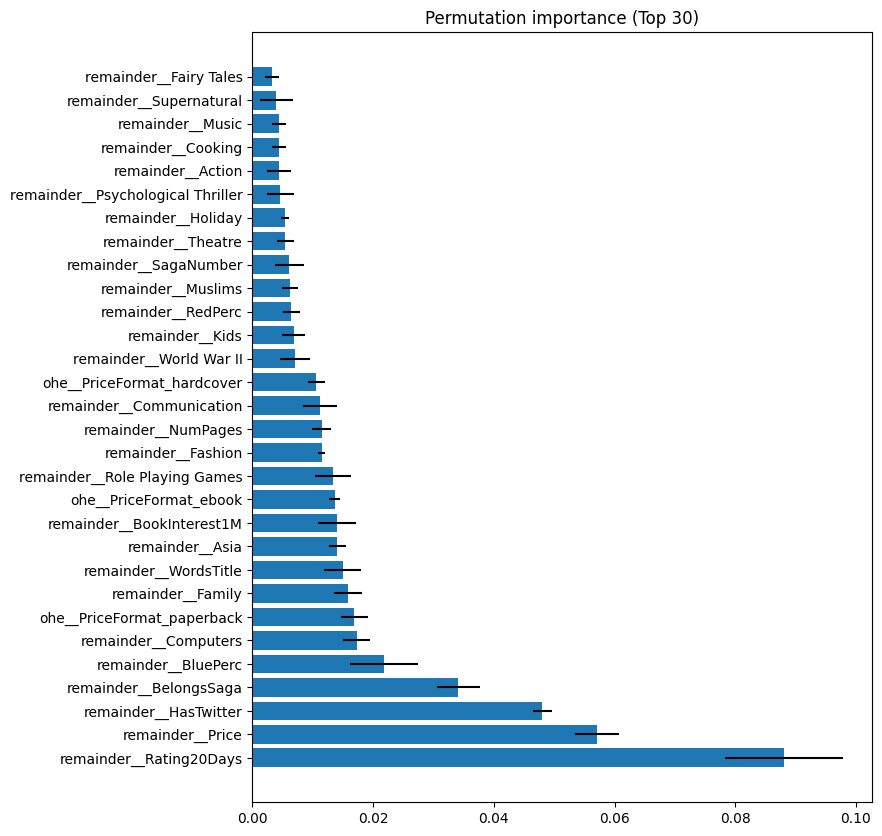

In [137]:
# Este código es una adaptación del código de los siguientes enlaces
# https://freedium.cfd/https://towardsdatascience.com/advanced-pipelines-with-scikit-learn-4204bb71019b
# https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html#feature-importance-by-permutation

def plot_feature_importances(perm_importance_result, feat_name, file_name, top_n=30, figsize=(8, 10)):
    """ bar plot the feature importance """
    fig, ax = plt.subplots(figsize=figsize)

    indices = perm_importance_result['importances_mean'].argsort()[::-1]

    
    # Filtramos solo las top_n características con mayor importancia
    top_indices = indices[:top_n]

    # Obtenemos las importancias y los nombres de las características correspondientes a las top_n características
    importancias_top = perm_importance_result['importances_mean'][top_indices]
    nombres_top = np.array(feat_name)[top_indices]

    # Gráfico de barras
    plt.barh(range(len(top_indices)),
             importancias_top,
             xerr=perm_importance_result['importances_std'][top_indices])

    ax.set_yticks(range(len(top_indices)))
    ax.set_yticklabels(nombres_top)

    ax.set_title("Permutation importance (Top 30)")

    plt.savefig(file_name)
    
    plt.show()

# Extract feature names after the transformation steps
# Therefore, we have to fit one part ([0:4]) of our pipeline to our data
ppl_fts = pipeline[2:3] # Solo hace OHE
ppl_fts.fit(X_train, y_train)
features = ppl_fts.get_feature_names_out()

# We provide the function our hyperparameter-tuned model/pipeline: clf
# In case we do not use hyperparameter tuning, we could provide here a fitted version of ppl
# For example: ppl.fit(X_train, y_train)
perm_importance_result_train = permutation_importance(grid_search, X_train, y_train, random_state=SEED)
plot_feature_importances(perm_importance_result_train, features, file_name='importancia_gridsearch.png')

En este gráfico se muestran las 30 variables con más importancia, ya que de las más de 300 variables muchas tienen importancia cero o cercana a cero. Las variables con más importancia son 'Rating20Days' (valoración media durante los 20 días siguientes a la publicación del libro), 'Price', 'HasTwitter' (si el autor tiene Twitter o no) y 'BelongsSaga' (si el libro pertenece a una saga o no).

Registramos los resultados en MLFlow

Almacenamos para cada métrica: 
  - su media y desviación típica para entrenamiento y validación
  - su valor para entrenamiento y validación en cada fold

In [83]:
# Registramos los resultados en MLFlow
with mlflow.start_run():

    # Almacena los valores de los hiperparámetros
    for key, value in best_params.items():
        mlflow.log_param(key, value)

    # Registra las métricas de cada fold para cada métrica
    for metric in METRICS:
        
        # Media
        mlflow.log_metric(f"mean_train_{metric}", df_cv_results[f"mean_train_{metric}"][index_row])
        mlflow.log_metric(f"mean_test_{metric}", df_cv_results[f"mean_test_{metric}"][index_row])

        # Desviación típica
        mlflow.log_metric(f"std_train_{metric}", df_cv_results[f"std_train_{metric}"][index_row])
        mlflow.log_metric(f"std_test_{metric}", df_cv_results[f"std_test_{metric}"][index_row])

        for i in range(5):

            # Resultados de entrenamiento en cada fold
            mlflow.log_metric(f"train_{metric}_fold_{i}", df_cv_results[f"split{i}_train_{metric}"][index_row])
            # Resultados de validación en cada fold
            mlflow.log_metric(f"test_{metric}_fold_{i}", df_cv_results[f"split{i}_test_{metric}"][index_row])

    # Registra el plot como un artefacto
    mlflow.log_artifact("importancia_gridsearch.png", artifact_path="plots")

    # Establece una etiqueta que describe el propósito de esta ejecución
    mlflow.set_tag("Información", "GridSearch 162 combinaciones")

    # Infiere el signature del modelo, que describe el tipo de entrada y salida del modelo
    signature = infer_signature(X_train, grid_search.best_estimator_.predict(X_train))

    # Registra el modelo
    model_info = mlflow.sklearn.log_model(
        sk_model=grid_search,
        artifact_path="rf_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="rf_gridsearch",
    )

c:\Users\carme\OneDrive - Universidad Complutense de Madrid (UCM)\SEGUNDO\SEGUNDO CUATRI\PD1\NOVELLA\venv\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/04/16 01:58:29 WARNING mlflow.utils.validation: Tag value '[{"run_id": "ea88379951384079b166f5f414b2f65b", "artifact_path": "rf_model", "utc_time_created": "20

### Ajuste de hiperparámetros con Randomized Search

A diferencia de grid search, esta estragia selecciona un valor aleatorio de un intervalo. Establecemos intervalos para cada parámetro con los mismos valores extremos que en grid search, para que ambas esttrategias sean comparables. Además establecemos el número de iteraciones a 162 ya que son las combinaciones que realizamos en grid search.

In [86]:
# Defino las distribuciones de los parámetros
param_dist = {
    'classifier__n_estimators': randint(10, 100),
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': randint(2, 11),
    'classifier__min_samples_leaf': randint(1, 5)
}

# Inicializo RandomizedSearch
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=162, cv=kf,
                                    scoring=METRICS,
                                    return_train_score=True,
                                    refit="balanced_accuracy",
                                    verbose=1,
                                    n_jobs=-1)

random_search.fit(X_train, y_train)

# Resultados
cv_results_rs = random_search.cv_results_
best_params_rs = random_search.best_params_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\carme\OneDrive - Universidad Complutense de Madrid (UCM)\SEGUNDO\SEGUNDO CUATRI\PD1\NOVELLA\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [87]:
# Convertimos los resultados de la validación cruzada en un dataframe
df_cv_results_rs = pd.DataFrame(cv_results_rs)
df_cv_results_rs

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,...,mean_test_specificity,std_test_specificity,rank_test_specificity,split0_train_specificity,split1_train_specificity,split2_train_specificity,split3_train_specificity,split4_train_specificity,mean_train_specificity,std_train_specificity
0,27.189561,1.846601,0.082231,0.017362,gini,20,2,9,84,"{'classifier__criterion': 'gini', 'classifier_...",...,0.952144,0.008513,34,0.977208,0.966952,0.976068,0.984055,0.986895,0.978235,0.006956
1,26.698629,1.771127,0.066142,0.022118,gini,10,4,2,28,"{'classifier__criterion': 'gini', 'classifier_...",...,0.919787,0.018731,159,0.941880,0.909402,0.926496,0.957289,0.951567,0.937327,0.017431
2,26.848303,1.341169,0.091507,0.032920,gini,10,2,7,42,"{'classifier__criterion': 'gini', 'classifier_...",...,0.927537,0.014043,134,0.935043,0.935043,0.940741,0.962984,0.967521,0.948266,0.014098
3,26.605559,2.037134,0.071423,0.034030,entropy,10,4,9,52,"{'classifier__criterion': 'entropy', 'classifi...",...,0.927534,0.013755,137,0.945869,0.917949,0.930484,0.952164,0.960114,0.941316,0.015200
4,25.455796,2.000831,0.065605,0.015700,gini,20,4,3,55,"{'classifier__criterion': 'gini', 'classifier_...",...,0.939379,0.016152,79,0.957835,0.949858,0.957835,0.966401,0.972650,0.960916,0.007862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,23.881794,0.566590,0.076911,0.014365,entropy,10,2,4,80,"{'classifier__criterion': 'entropy', 'classifi...",...,0.928899,0.014780,126,0.952137,0.944729,0.937322,0.958428,0.962963,0.951116,0.009230
158,24.163373,0.482061,0.052256,0.008025,gini,20,2,4,94,"{'classifier__criterion': 'gini', 'classifier_...",...,0.953966,0.012837,28,0.981197,0.973789,0.979487,0.985194,0.986895,0.981312,0.004608
159,23.525430,0.854832,0.061084,0.020778,gini,10,4,8,48,"{'classifier__criterion': 'gini', 'classifier_...",...,0.924803,0.014446,150,0.947009,0.921368,0.928775,0.955581,0.956125,0.941771,0.014208
160,23.820206,0.307563,0.058872,0.009798,gini,10,1,4,28,"{'classifier__criterion': 'gini', 'classifier_...",...,0.927989,0.010912,132,0.933903,0.933333,0.941311,0.966970,0.974359,0.949975,0.017284


In [88]:
# Seleccionamos la fila con los mejores parámetros
filtered_row_rs = df_cv_results.loc[
    (df_cv_results_rs['param_classifier__criterion'] == best_params_rs['classifier__criterion']) &
    (df_cv_results_rs['param_classifier__max_depth'] == best_params_rs['classifier__max_depth']) &
    (df_cv_results_rs['param_classifier__min_samples_leaf'] == best_params_rs['classifier__min_samples_leaf']) &
    (df_cv_results_rs['param_classifier__min_samples_split'] == best_params_rs['classifier__min_samples_split']) &
    (df_cv_results_rs['param_classifier__n_estimators'] == best_params_rs['classifier__n_estimators'])
]

# Obtenemos el índice
index_row_rs = filtered_row_rs.index[0]
index_row_rs

136

Importancia de las variables

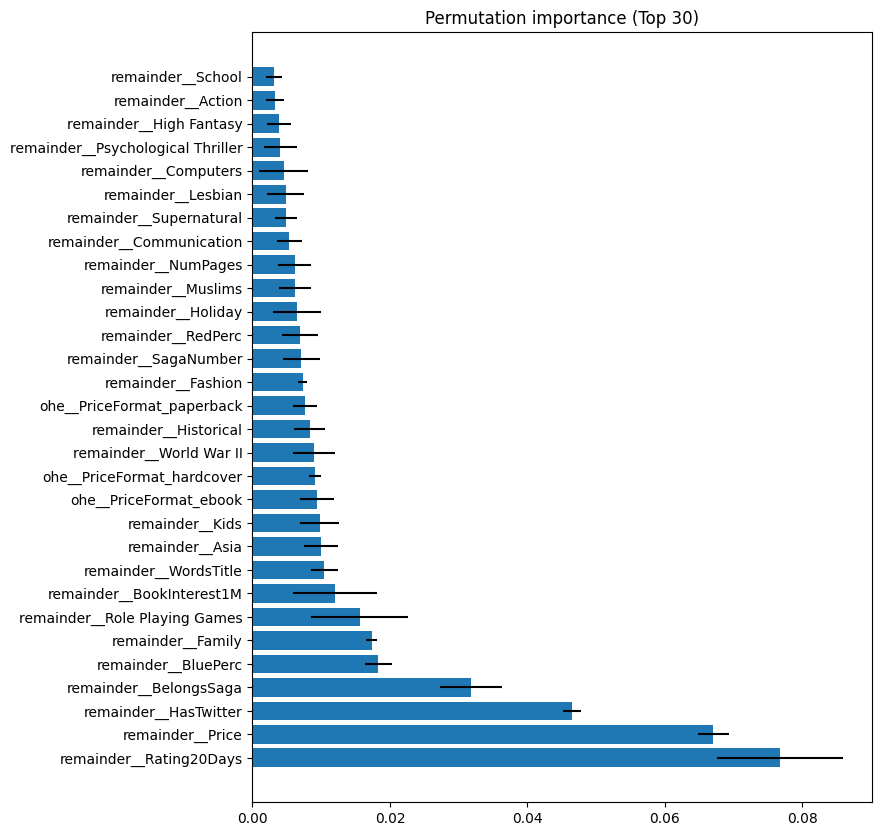

In [139]:
# Extraemos los nombres de las variables
ppl_fts = pipeline[2:3] # Solo hace OHE
ppl_fts.fit(X_train, y_train)
features = ppl_fts.get_feature_names_out()

perm_importance_result_train = permutation_importance(random_search, X_train, y_train, random_state=SEED)
plot_feature_importances(perm_importance_result_train, features, file_name='importancia_randomsearch.png')

Nos encontramos con que las variables con más importancia en el modelo de Random Search coinciden en su mayoría con las del modelo que empleaba Grid Search. Esta coincidencia es un buen indicativo ya que tiene sentido que las variables más importantes no cambien aunque cambie la estrategia de ajuste de hiperparámetros.

Registramos los resultados en MLFLow

Almacenamos para cada métrica: 
  - su media y desviación típica para entrenamiento y validación
  - su valor para entrenamiento y validación en cada fold

In [89]:
# Registramos los resultados en MLFlow
with mlflow.start_run():

    # Almacena los valores de los hiperparámetros
    for key, value in best_params_rs.items():
        mlflow.log_param(key, value)
    
    # Registra las métricas de cada fold para cada métrica
    for metric in METRICS:
        
        # Media
        mlflow.log_metric(f"mean_train_{metric}", df_cv_results_rs[f"mean_train_{metric}"][index_row_rs])
        mlflow.log_metric(f"mean_test_{metric}", df_cv_results_rs[f"mean_test_{metric}"][index_row_rs])

        # Desviación típica
        mlflow.log_metric(f"std_train_{metric}", df_cv_results_rs[f"std_train_{metric}"][index_row_rs])
        mlflow.log_metric(f"std_test_{metric}", df_cv_results_rs[f"std_test_{metric}"][index_row_rs])

        for i in range(5):

            # Resultados de entrenamiento en cada fold
            mlflow.log_metric(f"train_{metric}_fold_{i}", df_cv_results_rs[f"split{i}_train_{metric}"][index_row_rs])
            # Resultados de validación en cada fold
            mlflow.log_metric(f"test_{metric}_fold_{i}", df_cv_results_rs[f"split{i}_test_{metric}"][index_row_rs])

    # Registra el plot como un artefacto
    mlflow.log_artifact("importancia_randomsearch.png", artifact_path="plots")

    # Establece una etiqueta que describe el propósito de esta ejecución
    mlflow.set_tag("Información", "RandomizedSearch 162 iteraciones")

    # Infiere el signature del modelo, que describe el tipo de entrada y salida del modelo
    signature = infer_signature(X_train, random_search.best_estimator_.predict(X_train))

    # Registra el modelo
    model_info = mlflow.sklearn.log_model(
        sk_model=grid_search,
        artifact_path="rf_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="rf_randomsearch",
    )

c:\Users\carme\OneDrive - Universidad Complutense de Madrid (UCM)\SEGUNDO\SEGUNDO CUATRI\PD1\NOVELLA\venv\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/04/16 03:01:06 WARNING mlflow.utils.validation: Tag value '[{"run_id": "5b3dfcca2ef44fe4bf88c50b770e3bf9", "artifact_path": "rf_model", "utc_time_created": "20